<a href="https://colab.research.google.com/github/MCV-Jimenez/Sales-Analysis/blob/main/ML_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Linear Regression Analysis**

#Importing Libraries and Dataset

In [61]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config
set_config(display='diagram')

In [62]:
# Reading in dataset
df = pd.read_csv('/content/sales_predictions.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Inspecting Data and Addressing Discrepancies

In [63]:
# Inspecting data
print(df.info(), '\n')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None 

Item_Identifier                 0
Item

The missing values in the Item Weight column will be filled in during pipeline processing later. 

The Outlet Size column consists of Ordinal Data but it has missing values. To prep it for Machine Learning the values need to be Ordinal Encoded. Comparing the Outlet Sizes to Item Outlet Sales in the visuals below shows very close alignment between the data in the Missing category and the Small category. Since they are so closely aligned I will Ordinal Encode the Missing category to the same value as the Small category.  

In [64]:
# Filling in the missing values in Outlet Size for viewing purposes below
df['Outlet_Size'] = df[['Outlet_Size']].fillna("missing")

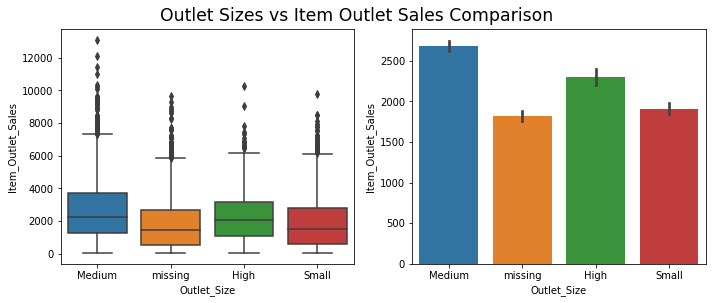

In [65]:
# Inspecting Outlet Size column
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
sns.boxplot(data=df, x='Outlet_Size', y='Item_Outlet_Sales', ax=axes[0])
sns.barplot(data=df, x='Outlet_Size', y='Item_Outlet_Sales', ax=axes[1])
fig.suptitle('Outlet Sizes vs Item Outlet Sales Comparison', y=1.04, size='xx-large')
fig.tight_layout();

In [66]:
# Ordinal Encoding Outlet Size column and Confirming result
df['Outlet_Size'].replace({'missing':1, 'Small':1, 'Medium':2, 'High':3}, inplace=True)
df['Outlet_Size'].value_counts()

1    4798
2    2793
3     932
Name: Outlet_Size, dtype: int64

# Identifying Feature Matrix(X), Target Vector(y), & Executing Train Test Split

In [67]:
X = df.drop(columns=['Item_Identifier', 'Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Pre Processing Pipeline

In [68]:
# Instantiating column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [69]:
# Instantiating imputers
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

In [70]:
# Instantiating column transformers
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [71]:
# Creating numeric & categoric pipelines
num_pipeline = make_pipeline(mean_imputer, scaler)
cat_pipeline = make_pipeline(freq_imputer, ohe)

In [72]:
# Tuples for the column tranformer
num_tuple = (num_pipeline, num_selector)
cat_tuple = (cat_pipeline, cat_selector)
# Column Transformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f56e93217d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f56e9321650>)])

# Regression Models

###Linear Regression Model

In [73]:
# Instantiating linear regression model in pipeline w/preprocessor
reg_pipe = make_pipeline(preprocessor, LinearRegression())
# Fitting linear regression model onto the training data
reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f56e93217d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f56e9321650>)])),
                ('linearregression', LinearRegression())])

In [74]:
# Obtaining the predictions for the train and test set for the following regression metrics
train_preds = reg_pipe.predict(X_train)
test_preds = reg_pipe.predict(X_test)

In [75]:
# Evaluating models performance unsing R^2
r2_train = r2_score(y_train, train_preds)
r2_test = r2_score(y_test, test_preds)
print(f"Training Model R^2 Score: {r2_train:,.2}")
print(f"Testing Model R^2 Score: {r2_test:,.2}")

Training Model R^2 Score: 0.56
Testing Model R^2 Score: 0.57


In [76]:
# Evaluating model's performance using RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
print(f"Training Model RMSE Score: {rmse_train:,.6}")
print(f"Testing Model RMSE Score: {rmse_test:,.6}")

Training Model RMSE Score: 1,138.95
Testing Model RMSE Score: 1,093.04


###Decision Tree Regression Model

In [77]:
# Instantiating Decision Tree Regression model in pipeline w/preprocessor
tree_pipe = make_pipeline(preprocessor, DecisionTreeRegressor())
# Fitting model onto training data
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f56e93217d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f56e9321650>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [78]:
# Obtaining the predictions of the train and test set for the following regression metrics
train_preds2 = tree_pipe.predict(X_train)
test_preds2 = tree_pipe.predict(X_test)

In [79]:
# Evaluating models performance unsing R^2
r2_train2 = r2_score(y_train, train_preds2)
r2_test2 = r2_score(y_test, test_preds2)
print(f"Training Model R^2 Score: {r2_train:,.2}")
print(f"Testing Model R^2 Score: {r2_test:,.2}")

Training Model R^2 Score: 0.56
Testing Model R^2 Score: 0.57


In [80]:
# Evaluating model's performance using RMSE
rmse_train2 = np.sqrt(mean_squared_error(y_train, train_preds2)) 
rmse_test2 = np.sqrt(mean_squared_error(y_test, test_preds2))
print(f"Training Model RMSE Score: {rmse_train2:,.6}")
print(f"Testing Model RMSE Score: {rmse_test2:,.6}")

Training Model RMSE Score: 0.0
Testing Model RMSE Score: 1,473.09


# Conclusion

Overall I would not recommend either model over the other for this dataset. Both models performed poorly on this dataset. Further analysis and model tuning will be required. 